In [3]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import glob


plt.rcParams["axes.linewidth"]  = 1.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=13)

import os
if os.environ['USER'] == 'dhayaa':
    os.environ['PATH'] = f"{os.environ['PATH']}:/software/texlive-2021-el7-x86_64/bin/x86_64-linux"
    
    
COLORS = ["f07167","219ebc","c767ac", "59a270", "ffba0a"]
COLORS = ['#' + c if c[0] != '#' else c for c in COLORS ]

from cycler import cycler

# Update the default prop_cycle
plt.rcParams['axes.prop_cycle'] = cycler(color=COLORS)

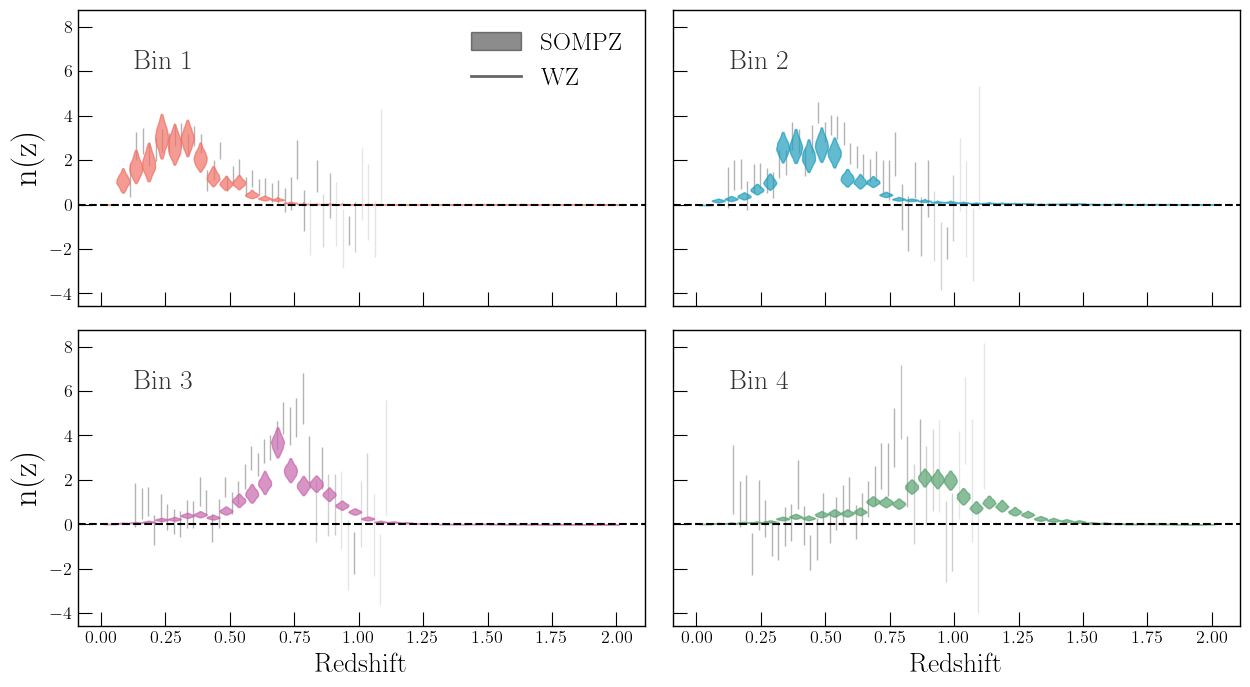

In [4]:
fig, ax = plt.subplots(2, 2, sharex = True, sharey = True, figsize = (15,  8))
ax = ax.flatten()
plt.subplots_adjust(wspace = 0.05, hspace = 0.08)

min_z   = 0.01
max_z   = 5
delta_z = 0.05
zbins   = np.arange(min_z,max_z+delta_z,delta_z)
zbinsc  = zbins[:-1]+(zbins[1]-zbins[0])/2.


X = np.load('/project/chihway/dhayaa/DECADE/SOMPZ/Runs/20240408/ZP/nz_Samp2.npy')

mask = (zbinsc > 0) & (zbinsc < 2.0)
X = np.sort(X, axis = 0)
X = X[int(X.shape[0] * 0.025) : int(X.shape[0] * 0.975)]


colors2 =['C0', 'C1', 'C2', 'C3']


Z  = np.load('/project/chihway/dhayaa/DECADE/Wz/20240423_Nz_NSIDE128_MainRun.py.npy', allow_pickle = True)[()]
z = np.linspace(0.1, 1.1, 41)
z = (z[1:] + z[:-1])/2

dz1 = delta_z
dz3 = z[1] - z[0]


for i in range(4):
    
    for j in range(Z['N_z'][i].size):
        
        a = 1 - 1.5*Z['dN_z'][i][j]/np.max(Z['dN_z'][i])
        a = np.clip(a, 0.1, 0.3)
        ax[i].errorbar(z[j] + 0.01*i, Z['N_z'][i][j] / dz3, yerr = Z['dN_z'][i][j] / dz3, elinewidth = 1, 
                       lw = 0, color  = 'k', alpha = a, zorder = -1000)
    
    parts2 = ax[i].violinplot(X[:,i, mask] / dz1,positions=zbinsc[mask],
                              widths=0.05, showmeans=False, showmedians=False, showextrema=False, )
    for pc in parts2['bodies']:
        pc.set_facecolor(colors2[i])
        pc.set_edgecolor(colors2[i])
        pc.set_alpha(0.7)
    

    
[a.axhline(0, color =  'k', ls = '--') for a in ax.flat]
[a.set_xlabel('Redshift', size = 20) for a in ax[2:].flat]
ax[0].set_ylabel('n(z)', size = 25)
ax[2].set_ylabel('n(z)', size = 25)

# ax[0].set_xticks([0,  0.5, 1.0, 1.5, 2.0])
# ax[0].set_xticklabels([0,  0.5, 1.0, 1.5, 2.0])

[a.text(0.1, 0.8, 'Bin %d' % (i + 1), size = 20, transform = a.transAxes, color = 'k', alpha = 0.8) 
 for i, a in enumerate(ax.flatten())]


ax[0].legend([plt.fill_between([], [], alpha = 0.45, color = 'k'),
              plt.errorbar([], [],yerr = [], color = 'k', alpha = 0.6, lw = 2)[0], ],
             ['SOMPZ', 'WZ'], fontsize = 18)

plt.savefig('./nofz_fid.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()